# Section 1: Import Packages

In [8]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Section 2: Data Preprocessing

### Tumor Classification

In [9]:
path='./Data'
pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,.DS_Store
1,meningioma_tumor
2,glioma_tumor
3,pituitary_tumor
4,normal


### Creating a Test set (10%)

In [10]:
import os
import shutil
import random

# Set the path to your 'Data' folder
data_folder = './Data'

# Set the path to the new folder where you want to move 10% of the images
new_folder = './Test'

# Define the percentage of images to move (in this case, 10%)
percentage_to_move = 0.1


# Create the new folder if it doesn't exist
if not os.path.exists(new_folder):
    os.makedirs(new_folder)
    
    for child_folder in os.listdir(data_folder):
        child_folder_path = os.path.join(data_folder, child_folder)
        
        if child_folder_path == "./Data/.DS_Store": continue

        print(child_folder_path)

        # Create a corresponding child folder in the new folder
        new_child_folder_path = os.path.join(new_folder, child_folder)
        if not os.path.exists(new_child_folder_path):
            os.makedirs(new_child_folder_path)

        # Get a list of all image files in the current child folder
        image_files = [f for f in os.listdir(child_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

        # Calculate the number of images to move (10% of the total)
        num_images_to_move = int(len(image_files) * percentage_to_move)

        # Randomly select images to move
        images_to_move = random.sample(image_files, num_images_to_move)

        # Move the selected images to the new folder
        for img in images_to_move:
            src_path = os.path.join(child_folder_path, img)
            dest_path = os.path.join(new_child_folder_path, img)
            shutil.move(src_path, dest_path)
    
    print("Images moved successfully.")

### Data Splitting (70% for training, 30% for validation)


In [11]:
# Define the directory containing your image data
data_directory = path

# Create a TensorFlow dataset
batch_size = 32
image_size = (256, 256)  # Adjust the size as needed
validation_split = 0.3

# Create a training set
train = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=validation_split,  # 30% of the data for validation
    subset="training",
    seed=123,  # Set a random seed for reproducibility
    image_size=image_size,
    batch_size=batch_size,
)

# Create a validation and test set
validation = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,  # 30% of the data for validation
    subset="validation",
    seed=123,  # Use the same seed for consistency
    image_size=image_size,
    batch_size=batch_size,
)

Found 2788 files belonging to 4 classes.
Using 1952 files for training.
Found 2788 files belonging to 4 classes.
Using 557 files for validation.


### Class names

In [12]:
class_names = train.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

### Images

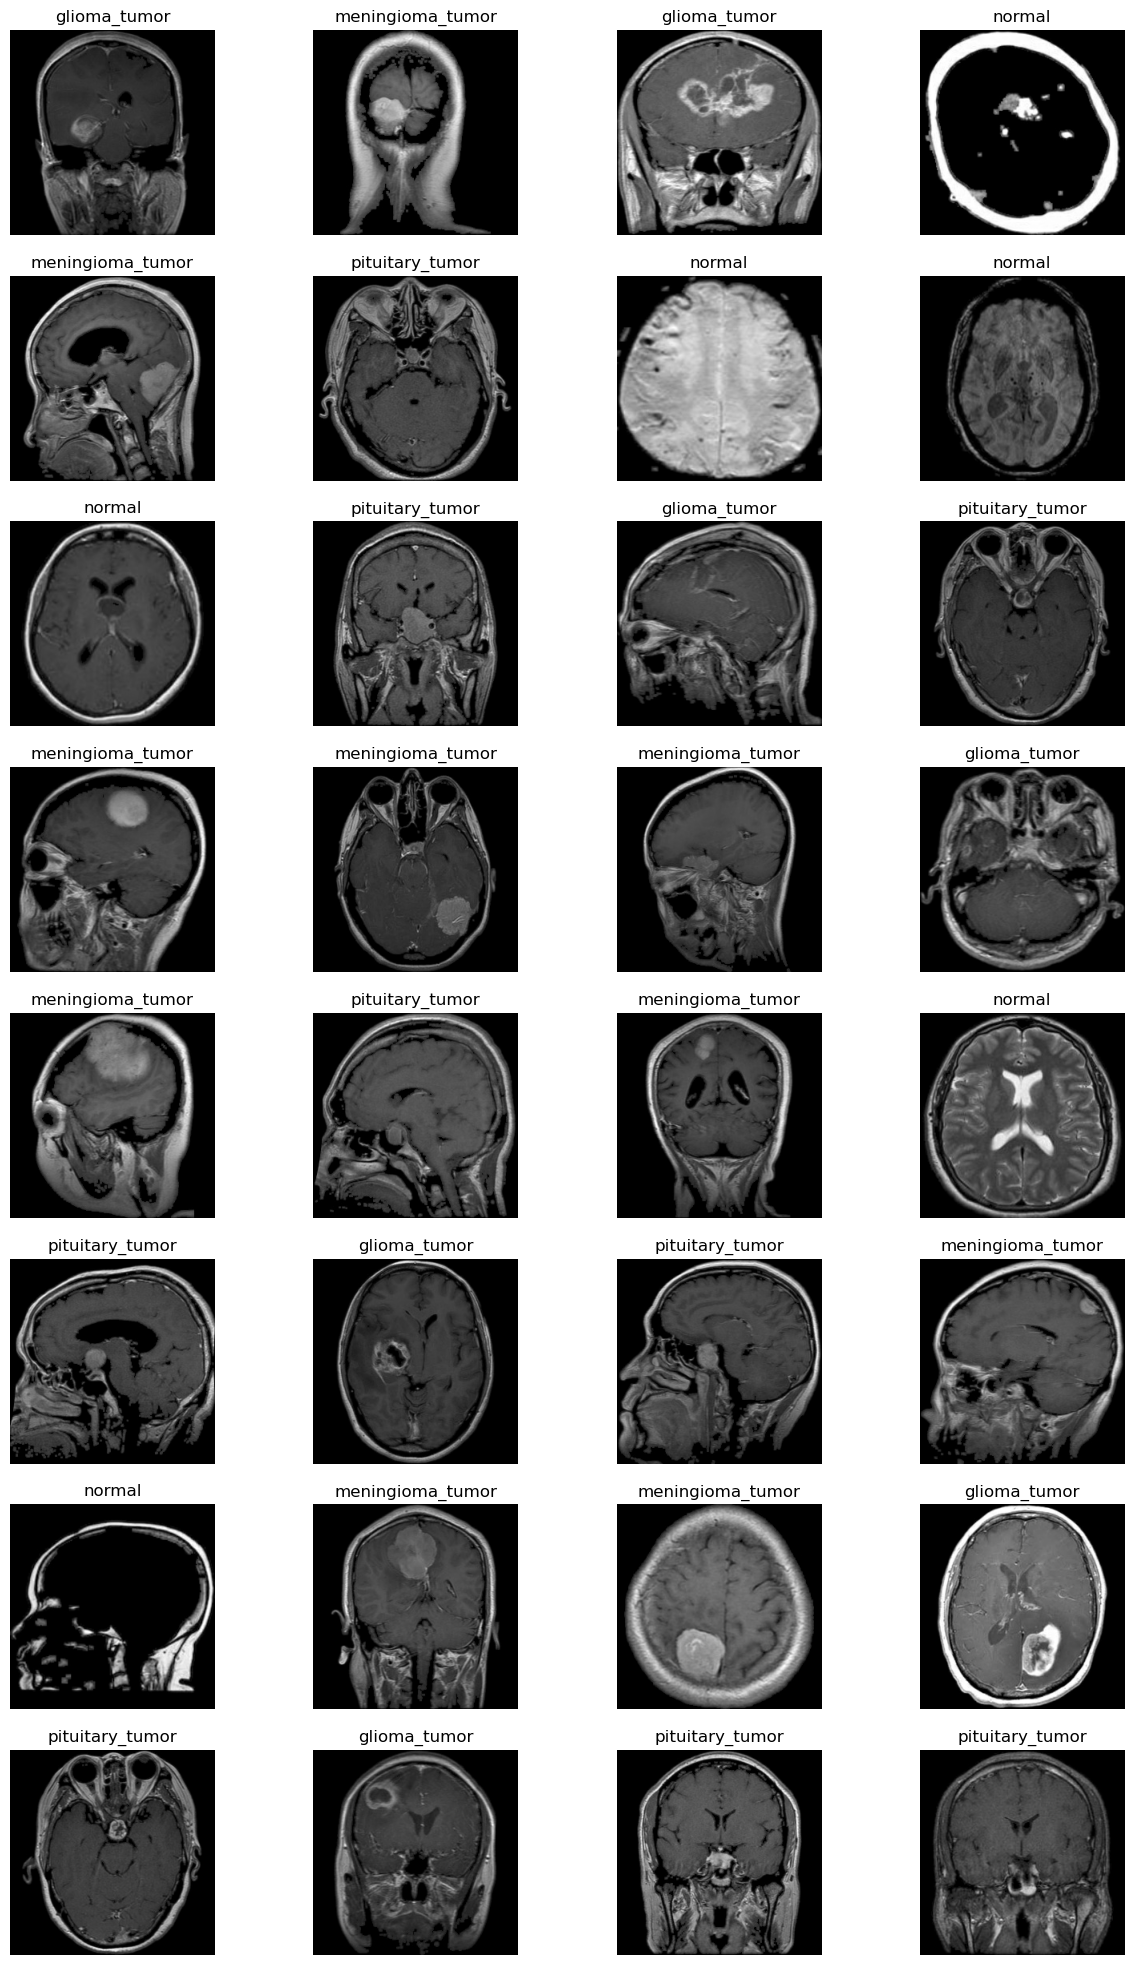

In [13]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1): # iterate over the 1st batch in train set
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        

### Training data augmentation

# Section 3: Building CNN

### Initializing the CNN

In [101]:
cnn = tf.keras.models.Sequential()

### Convolution

In [102]:
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=[256,256,3]))

### Pooling

In [103]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2))

### Adding a second convolutional layer

In [104]:
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2))

### Adding a third convolutional layer

In [105]:
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2))

### Flattening

In [106]:
cnn.add(tf.keras.layers.Flatten())

### Fully Connection

In [107]:
# cnn.add(tf.keras.layers.Dense(units=32,activation='relu'))
cnn.add(tf.keras.layers.Dense(units=16,activation='relu'))

### Output Layer

In [108]:
cnn.add(tf.keras.layers.Dense(units=4,activation='softmax'))

### Model Summary

In [22]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

# Section 4: Training the CNN

### Compiling the CNN

In [109]:
cnn.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics = ['accuracy']
)

### Training the CNN on Training set

In [110]:
# train is a Tensorflow dataset that contains both the input data and labels, so there's no need to split it into x and y separately
cnn.fit(train, validation_data = validation, epochs = 10)

Epoch 1/10
61/61 [==============================] - 36s 591ms/step - loss: 17.0737 - accuracy: 0.3622 - val_loss: 1.1856 - val_accuracy: 0.4811
Epoch 2/10
61/61 [==============================] - 36s 586ms/step - loss: 0.9677 - accuracy: 0.5902 - val_loss: 1.0068 - val_accuracy: 0.5996
Epoch 3/10
61/61 [==============================] - 36s 583ms/step - loss: 0.7094 - accuracy: 0.7259 - val_loss: 0.8604 - val_accuracy: 0.6786
Epoch 4/10
61/61 [==============================] - 36s 585ms/step - loss: 0.5106 - accuracy: 0.8033 - val_loss: 0.8435 - val_accuracy: 0.7253
Epoch 5/10
61/61 [==============================] - 36s 585ms/step - loss: 0.3870 - accuracy: 0.8468 - val_loss: 0.9975 - val_accuracy: 0.7127
Epoch 6/10
61/61 [==============================] - 36s 587ms/step - loss: 0.2671 - accuracy: 0.9083 - val_loss: 1.0719 - val_accuracy: 0.7271
Epoch 7/10
61/61 [==============================] - 36s 584ms/step - loss: 0.1579 - accuracy: 0.9462 - val_loss: 1.3546 - val_accuracy: 0.773

# Section 5: Evaluating the CNN

### Making a single prediction 

Result: pituitary_tumor
1/1 [==============================] - 0s 20ms/step
3
Result:  pituitary_tumor


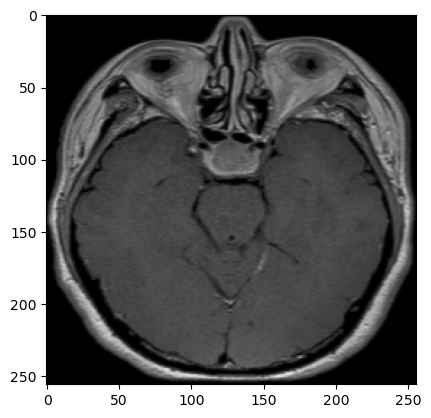

In [83]:
from keras.preprocessing import image

image_type = "pituitary_tumor" 

single_prediction_pituitary_path = os.path.join("./Test", image_type)

all_files = os.listdir(single_prediction_pituitary_path)

image_files = [f for f in all_files if f.lower().endswith(( '.jpg'))]

# Check if there are any image files in the folder
if len(image_files) == 0:
    print("No image files found in the folder.")
else:
    # Choose a random image file
    random_image = random.choice(image_files)
    print("Result:", image_type)
    

    random_image_path = os.path.join(single_prediction_pituitary_path, random_image)


test_img = image.load_img(random_image_path, target_size=(256,256))
plt.imshow(test_img)
test_img = image.img_to_array(test_img)

# We train the CNN based on batch so we need to convert test_img into batch (adding 1 more dimension)
test_img = np.expand_dims(test_img, axis=0)

model_predict = tf.nn.softmax(cnn.predict(test_img))
class_index = np.argmax(model_predict.numpy())

print(class_index)

print("Result: ", class_names[class_index])

### Evaluate model

In [100]:
from keras.preprocessing import image

image_type = "meningioma_tumor" 

prediction_path = os.path.join("./Test", image_type)

all_files = os.listdir(prediction_path)

accuracy_count = 0

# Filter out only image files (adjust the list of valid extensions as needed)
image_files = [f for f in all_files if f.lower().endswith(('.jpg'))]

for image_file in image_files:
    if len(image_files) == 0:
        print("No image files found in the folder.")
    else:
        # Choose a random image file
        random_image = random.choice(image_files)

        print("Result: ", image_type)


        random_image_path = os.path.join(prediction_path, random_image)

        test_img = image.load_img(random_image_path, target_size=(256,256))
        test_img = image.img_to_array(test_img)

        test_img = np.expand_dims(test_img, axis=0)

        # result = cnn.predict(test_img)
        model_predict = tf.nn.softmax(cnn.predict(test_img))
        class_index = np.argmax(model_predict.numpy())
        
        if (class_names[class_index] == image_type):
            accuracy_count += 1
            
print(accuracy_count/len(image_files))

Result:  meningioma_tumor
1/1 [==============================] - 0s 22ms/step
Result:  meningioma_tumor
1/1 [==============================] - 0s 18ms/step
Result:  meningioma_tumor
1/1 [==============================] - 0s 18ms/step
Result:  meningioma_tumor
1/1 [==============================] - 0s 17ms/step
Result:  meningioma_tumor
1/1 [==============================] - 0s 17ms/step
Result:  meningioma_tumor
1/1 [==============================] - 0s 18ms/step
Result:  meningioma_tumor
1/1 [==============================] - 0s 18ms/step
Result:  meningioma_tumor
1/1 [==============================] - 0s 17ms/step
Result:  meningioma_tumor
1/1 [==============================] - 0s 17ms/step
Result:  meningioma_tumor
1/1 [==============================] - 0s 19ms/step
Result:  meningioma_tumor
1/1 [==============================] - 0s 18ms/step
Result:  meningioma_tumor
1/1 [==============================] - 0s 18ms/step
Result:  meningioma_tumor
1/1 [==============================] -

In [94]:
# from sklearn.metrics import accuracy_score

# test_directory = "./Test"

# test = tf.keras.utils.image_dataset_from_directory(
#     test_directory,
#     seed=123,  # Set a random seed for reproducibility
#     image_size=image_size,
#     batch_size=batch_size,
# )

# training_error = cnn.evaluate(test)
# validation_error = cnn.evaluate(test)

# print("Training error:", training_error)
# print("Validation error:", validation_error)



Found 308 files belonging to 4 classes.


NameError: name 'model' is not defined